In [1]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_set = load('../dataresult/train_set')
    train_label = load('../dataresult/train_label')
    # 测试集
    test_set = load('../dataresult/test_set')
    test_label = load('../dataresult/test_label')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=batch_size, num_workers=workers, drop_last=True)
    return train_loader, test_loader

batch_size = 16
# 加载数据
train_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(test_loader))

16
9


In [12]:
# 定义 CNNModel 模型
class CNNModel(nn.Module):
    def __init__(self, input_dim, conv_archs, output_dim):
        """
        预测任务  params:
        input_dim          : 输入数据的维度
        conv_archs         : cnn 网络结构
        output_dim         : 输出维度数
        """
        super().__init__()
        # CNN参数
        self.conv_arch = conv_archs # cnn网络结构
        self.input_channels = input_dim # 输入通道数
        self.cnn_features = self.make_layers()

        # 平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # 定义线性层
        self.linear  = nn.Linear(conv_archs[-1][-1], output_dim)

    # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    def forward(self, input_seq):  
        batch_size = input_seq.size(0)
        # CNN 卷积池化
        # CNN 网络输入[batch, dim, seq_length]
        # 改变输入形状
        input_seq = input_seq.permute(0, 2, 1)
        cnn_features = self.cnn_features(input_seq) # torch.Size([32, 64, 1])
        # 平均池化
        x = self.avgpool(cnn_features)          # ttorch.Size([32, 64, 1])
        # 平铺
        flat_tensor = x.view(batch_size, -1) # torch.Size([32, 64])
        predict = self.linear(flat_tensor) 
        return predict

In [ ]:
# 定义模型参数
input_dim = 14   # 输入维度为14维数据
# CNN 网络结构 参考经典CNN网络模型 VGG 必看，不然看不懂相关参数设置
conv_archs = ((1, 32), (1, 64))  # 层数，和每层通道数
output_dim = 1 # 输出维度为 1

model = CNNModel(input_dim, conv_archs, output_dim)  

# 定义损失函数和优化函数
loss_function = nn.MSELoss()  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

  1344
    32
  6144
    64
    64
     1
______
  7649


In [4]:
print(model)

CNNModel(
  (cnn_features): Sequential(
    (0): Conv1d(14, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)


Epoch:  1 train_MSE-Loss: 0.90087783
Epoch:  2 train_MSE-Loss: 0.76282974
Epoch:  3 train_MSE-Loss: 0.65558365
Epoch:  4 train_MSE-Loss: 0.54860453
Epoch:  5 train_MSE-Loss: 0.43549365
Epoch:  6 train_MSE-Loss: 0.32376874
Epoch:  7 train_MSE-Loss: 0.22602684
Epoch:  8 train_MSE-Loss: 0.15034132
Epoch:  9 train_MSE-Loss: 0.09917884
Epoch: 10 train_MSE-Loss: 0.07181270
Epoch: 11 train_MSE-Loss: 0.05948057
Epoch: 12 train_MSE-Loss: 0.05172120
Epoch: 13 train_MSE-Loss: 0.04468889
Epoch: 14 train_MSE-Loss: 0.03848817
Epoch: 15 train_MSE-Loss: 0.03338746
Epoch: 16 train_MSE-Loss: 0.02930541
Epoch: 17 train_MSE-Loss: 0.02600013
Epoch: 18 train_MSE-Loss: 0.02336639
Epoch: 19 train_MSE-Loss: 0.02128012
Epoch: 20 train_MSE-Loss: 0.01962141
Epoch: 21 train_MSE-Loss: 0.01827638
Epoch: 22 train_MSE-Loss: 0.01711685
Epoch: 23 train_MSE-Loss: 0.01608228
Epoch: 24 train_MSE-Loss: 0.01514243
Epoch: 25 train_MSE-Loss: 0.01429816
Epoch: 26 train_MSE-Loss: 0.01350462
Epoch: 27 train_MSE-Loss: 0.01277092
E

findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsof

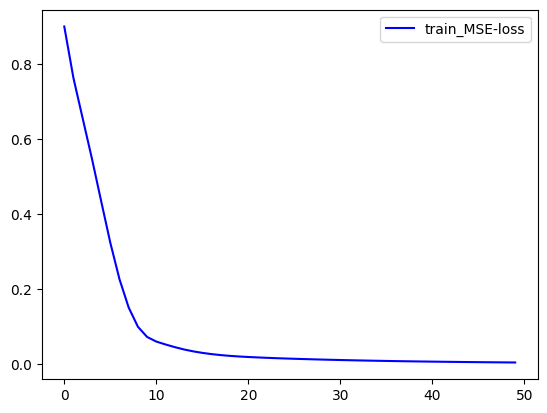

min_MSE: 0.003641097791842185


In [4]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(epochs, model, optimizer, loss_function, train_loader, device):
    model = model.to(device)

    # 最低MSE  
    minimum_mse = 1000.
    # 最佳模型
    best_model = model

    train_mse = []     # 记录在训练集上每个epoch的 MSE 指标的变化情况   平均值
  
    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
         # 训练
        model.train()
        train_mse_loss = []    #保存当前epoch的MSE loss和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 损失计算
            loss = loss_function(y_pred, labels)
            train_mse_loss.append(loss.item()) # 计算 MSE 损失
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算总损失
        train_av_mseloss = np.average(train_mse_loss) # 平均
        train_mse.append(train_av_mseloss)
        print(f'Epoch: {epoch+1:2} train_MSE-Loss: {train_av_mseloss:10.8f}')
       
        # 如果当前模型的 MSE 低于于之前的最佳准确率，则更新最佳模型
        #保存当前最优模型参数
        if train_av_mseloss < minimum_mse:
            minimum_mse = train_av_mseloss
            best_model = model# 更新最佳模型的参数
         
    # 保存最后的参数
    # torch.save(model, 'final_model_cnn.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn.pt')
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    
    # 可视化
    plt.plot(range(epochs), train_mse, color = 'b',label = 'train_MSE-loss')
    plt.legend()
    plt.show()   #显示 lable 
    print(f'min_MSE: {minimum_mse}')

#  模型训练
epochs = 50
model_train(epochs, model, optimizer, loss_function, train_loader, device)

### 第一部分，训练集评估

In [6]:
# 模型预测
# 模型 测试集 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn.pt', weights_only=False)
model = model.to(device)

# 预测数据
origin_data = []
pre_data = []
with torch.no_grad():
        for data, label in train_loader:
            # 原始标签
            origin_lable = label.tolist()
            origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            train_pred = model(data)  # 对测试集进行预测
            train_pred = train_pred.tolist()
            pre_data += train_pred      

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
origin_data = scaler.inverse_transform(origin_data)
pre_data = scaler.inverse_transform(pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(origin_data, pre_data)
print('训练集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
train_mse = mean_squared_error(origin_data, pre_data)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(origin_data, pre_data)
print('训练数据集上的均方误差-MSE: ',train_mse)
print('训练数据集上的均方根误差-RMSE: ',train_rmse)
print('训练数据集上的平均绝对误差-MAE: ',train_mae)

训练集上 模型分数-R^2: 0.9960050669079574
**************************************************
训练数据集上的均方误差-MSE:  0.00027877002427877074
训练数据集上的均方根误差-RMSE:  0.0166964075261348
训练数据集上的平均绝对误差-MAE:  0.013315782707294964


/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# 测试集评估

In [9]:
# 模型 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('best_model_cnn.pt', weights_only=False)
model = model.to(device)

# 预测数据
test_origin_data = []
test__pre_data = []
with torch.no_grad():
        for data, label in test_loader:
            # 原始标签
            origin_lable = label.tolist()
            test_origin_data += origin_lable
            model.eval()  # 将模型设置为评估模式
            
            # 预测
            data, label = data.to(device), label.to(device)
            pred = model(data)  # 对测试集进行预测
            pred = pred.tolist()
            test__pre_data += pred        

In [10]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 反归一化处理
# 使用相同的均值和标准差对预测结果进行反归一化处理
# 反标准化
scaler  = load('../dataresult/scaler')
test_origin_data = scaler.inverse_transform(test_origin_data)
test__pre_data = scaler.inverse_transform(test__pre_data)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
score = r2_score(test_origin_data, test__pre_data)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(test_origin_data, test__pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(test_origin_data, test__pre_data)
print('测试数据集上的均方误差-MSE: ',test_mse)
print('测试数据集上的均方根误差-RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差-MAE: ',test_mae)

测试集上 模型分数-R^2: 0.9930551678706229
**************************************************
测试数据集上的均方误差-MSE:  0.0004806958468791758
测试数据集上的均方根误差-RMSE:  0.02192477700865338
测试数据集上的平均绝对误差-MAE:  0.016037672220025376


/opt/conda/envs/py39/lib/python3.9/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.
findfont: Font family 'Microsoft YaHei' not found.


findfont: Font family 'Microsoft YaHei' not found.
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23551 (\N{CJK UNIFIED IDEOGRAPH-5BFF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21629 (\N{CJK UNIFIED IDEOGRAPH-547D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30334 (\N{CJK UNIFIED IDEOGRAPH-767E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/envs/py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarn

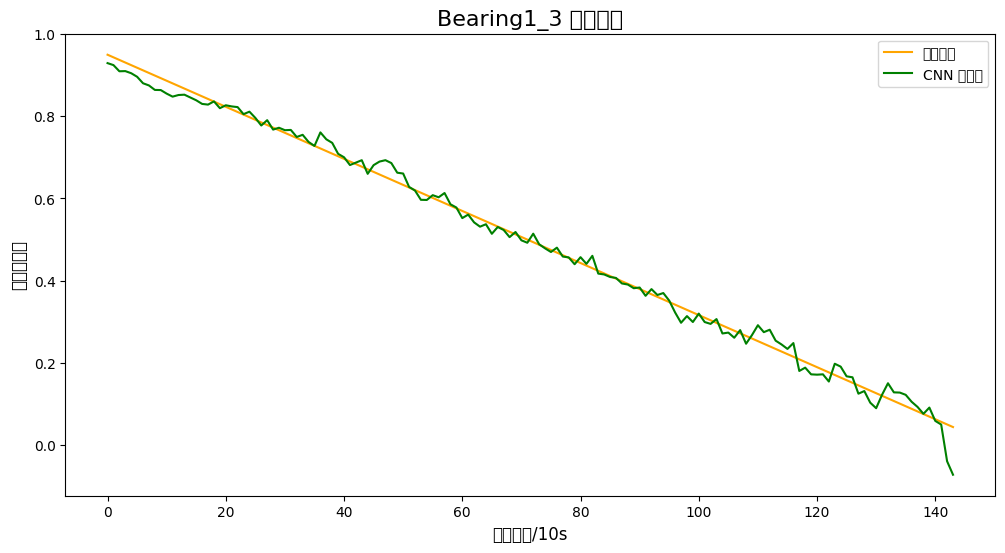

['../画图对比/cnn_pre']

In [11]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test_origin_data, label='真实寿命',color='orange')  # 真实值
plt.plot(test__pre_data, label='CNN 预测值',color='green')  # 预测值

# plt.plot([-1,170],[2.0*0.7,2.0*0.7],c='black',lw=1,ls='--')  # 临界点直线  可自己调整位置

plt.xlabel('运行周期/10s', fontsize=12)
plt.ylabel('寿命百分比', fontsize=12)
plt.title('Bearing1_3 预测结果', fontsize=16)
plt.legend()
plt.show()

# 保存数据
# 保存数据
dump(test_origin_data, '../画图对比/cnn_origin') 
dump(test__pre_data, '../画图对比/cnn_pre') 